In [1]:
import pandas as pd
import numpy as np
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt

from read_data import read_data_mmu

In [2]:
mmu_data = read_data_mmu('TPM')


In [48]:
mmu_data

,Gene Symbol,s2a TPM,s2b TPM,s2c TPM,s3a TPM,s3b TPM,s3c TPM,s4a TPM,s4b TPM,s4c TPM,s1a TPM,s1c TPM,s5a TPM,s5b TPM,s6a TPM,s6b TPM,s7c TPM
0,Zglp1,0.09,0.00,0.00,0.27,0.00,0.00,0.10,0.00,0.00,0.09,0.00,0.56,0.00,0.10,0.00,0.00
1,Ldlrap1,7.83,14.09,0.66,11.72,1.85,42.08,12.06,3.40,27.67,7.61,21.58,13.36,13.08,6.32,7.58,0.00
2,Mdn1,0.86,0.24,0.00,0.86,0.00,0.00,1.09,0.00,0.00,0.75,0.00,0.83,0.98,0.92,0.24,0.00
3,Ifi208,0.64,0.00,0.00,0.27,0.00,0.00,0.66,0.00,0.00,0.41,0.00,0.51,0.00,0.88,1.32,0.00
4,Wfdc17,103.26,1755.21,966.29,98.26,1353.87,1679.04,131.14,2190.17,1119.97,110.01,2241.48,101.34,2290.24,72.24,2116.42,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16640,Arfip1,4.85,4.00,0.00,5.60,3.50,0.00,6.54,1.60,0.00,5.87,0.00,7.27,2.78,3.25,4.85,0.00
16641,Prmt6,1.02,0.00,0.00,1.71,0.00,0.00,1.64,0.00,0.00,0.99,0.00,1.91,0.00,1.27,0.00,0.00
16642,Ifi44,11.88,56.21,30.73,7.22,21.16,0.00,15.58,77.28,124.95,18.79,33.65,15.55,58.98,15.14,64.43,0.00
16643,Tiparp,0.86,1.86,0.00,1.44,0.00,0.00,1.64,0.77,0.00,1.06,0.00,1.29,0.00,1.21,1.07,4.32


In [ ]:
#### pearson correlation mmu
sns.set_theme(color_codes=True,font = 'Arial', font_scale =1.2)
ax = sns.clustermap(mmu_data.corr(method='pearson'),cmap='RdBu_r',method='complete', annot= True, figsize=(15,15))



In [41]:
#### identify liver specific gene

mmu_all_tissue = pd.read_csv('../data/mmu_all_tissue/mouse_tissue.csv',sep='\t', index_col=0)

#print(mmu_all_tissue.head())

## remove sex organ
sex_organ = ['mOv', 'mTe', 'mUt', 'mVg']
select_sample = [i for i in mmu_all_tissue.columns.values if i.split('_')[0] not in sex_organ ]
mmu_normal_organ = mmu_all_tissue.loc[:,select_sample]
#####  remove non-coding gene
mmu_protein = mmu_normal_organ.loc[mmu_normal_organ['gene_type'] == 'protein_coding']
mmu_protein.index = mmu_protein['gene_short_name']
mmu_protein = mmu_protein.iloc[:,2:]

#### pre-preocessing

#### pre-preocessing
tissue_rna_protein = mmu_protein
### remove low expression
min_vlaue = 1
tissue_name_normal = np.unique(np.array([i.split('_')[0] for i in  tissue_rna_protein.columns]))

tissue_rna_protein_filter1 = tissue_rna_protein.loc[(tissue_rna_protein.quantile(0.75,axis=1)>0) & (tissue_rna_protein.T.max() >= min_vlaue)]
tissue_rna_protein_filter1 = np.log2(tissue_rna_protein_filter1+1)

print('After pre-processing, remaining {} genes'.format(tissue_rna_protein_filter1.shape[0]))


for select_tissue in tissue_name_normal:
    globals()['tissue_select_' + select_tissue] = tissue_rna_protein_filter1.loc[:,[i for i in tissue_rna_protein_filter1.columns.values if i.split('_')[0] == select_tissue]]

tissue_name_1 = 'mLi'
tissue_name_remain = np.delete(tissue_name_normal,np.where(tissue_name_normal == tissue_name_1))       #choose tissue_name_1 vs other tissue

#######  t test

from scipy import stats



p_value = 0.05


for tissue_name in tissue_name_remain:
    globals()[tissue_name_1+'_'+tissue_name+'_pvalue'] = stats.ttest_ind(eval('tissue_select_'+ tissue_name_1).T,eval('tissue_select_'+ tissue_name).T,equal_var=False).pvalue
    #print(stats.ttest_ind(eval('tissue_select_'+ tissue_name_1).T,eval('tissue_select_'+ tissue_name).T,equal_var=False).pvalue<0.05)
#print(eval(tissue_name_1 + '_' + tissue_name_remain[0] + '_pvalue'))
flag = (eval(tissue_name_1 + '_' + tissue_name_remain[0] + '_pvalue')<p_value)
for tissue_name in tissue_name_remain:
    flag = (flag) & (eval(tissue_name_1 + '_' + tissue_name + '_pvalue')<p_value)
print(flag)
tissue_rna_protein_filter2 = tissue_rna_protein_filter1.iloc[np.where(flag==True)[0],:]
tissue_rna_protein_filter2
print('After t-test, remaining {} genes'.format(len(tissue_rna_protein_filter2.index)))


####### fold change analysis
fold_change = 7

for select_tissue in tissue_name_normal:
    globals()['tissue_select_' + select_tissue] = tissue_rna_protein_filter2.loc[:,[i for i in tissue_rna_protein_filter2.columns.values if i.split('_')[0] == select_tissue]]

flag_fc =  (eval('tissue_select_'+tissue_name_1).T.mean() - eval('tissue_select_'+tissue_name_normal[0]).T.mean())>fold_change
for tissue_name in tissue_name_remain:
    flag_fc = (flag_fc) & (eval('tissue_select_'+tissue_name_1).T.mean() - eval('tissue_select_'+tissue_name).T.mean())
tissue_rna_protein_filter3 = tissue_rna_protein_filter2.iloc[np.where(flag_fc==True)[0],:]
tissue_rna_protein_filter3
print('After FC_analysis, remaining {} genes'.format(len(tissue_rna_protein_filter3.index)))
for select_tissue in tissue_name_normal:
    globals()['tissue_select_' + select_tissue] = tissue_rna_protein_filter3.loc[:,[i for i in tissue_rna_protein_filter3.columns.values if i.split('_')[0] == select_tissue]]

liver_specific_gene = tissue_select_mLi.index.values
liver_specific_gene

After pre-processing, remaining 16958 genes
[False False False ... False False  True]
After t-test, remaining 3343 genes
After FC_analysis, remaining 29 genes


array(['Apoh', 'Cyp2c29', 'Apoa2', 'Akr1c6', 'Ahsg', 'Cps1', 'Serpinc1',
       'Fga', 'Uox', 'Ambp', 'Pzp', 'Hpx', 'Apoa1', 'Fgb', 'Fgg', 'Gc',
       'Azgp1', 'Mat1a', 'Fabp1', 'Cyp3a11', 'Ces1c', 'Serpina3k', 'Plg',
       'Mug1', 'Ttr', 'Mup3', 'Serpina1a', 'Serpina1b', 'Mup10'],
      dtype=object)

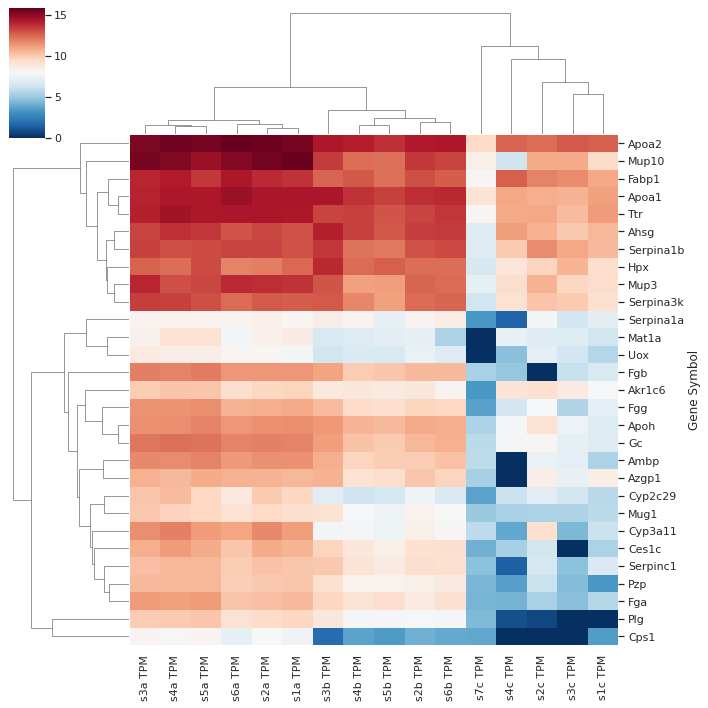

In [52]:
mmu_data_specific_gene = mmu_data.iloc[[i for i in range(mmu_data.shape[0]) if mmu_data.iloc[i]['Gene Symbol'] in liver_specific_gene]]
mmu_data_specific_gene.index = mmu_data_specific_gene['Gene Symbol']
mmu_data_specific_gene = mmu_data_specific_gene.iloc[:,1:]
sns.set_theme(color_codes=True)
ax = sns.clustermap(np.log2(mmu_data_specific_gene+1),cmap='RdBu_r', yticklabels = True,figsize=(10,10))


<AxesSubplot:ylabel='Term|NES'>

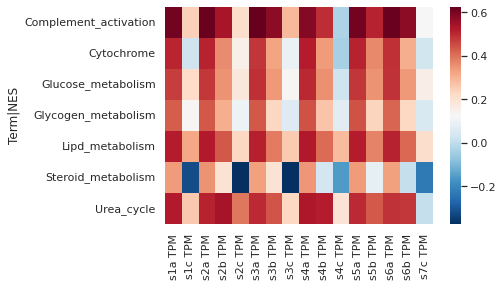

In [51]:
#### mmu ssgsea

pathway = pd.read_csv('../data/mmu_data/Pathway.csv',sep='\t')
pathway_dict = {i:[x for x in pathway[i].values if x == x] for i in pathway}
ss = gp.ssgsea(data = mmu_data, gene_sets= pathway_dict,
                outdir= '../results/mmu_ssgsea/',
                sample_norm_method='rank', permutation_num=0,  processes=4, scale=True, min_size=2
)  
temp = ss.res2d.columns.values
x = np.sort(temp)
ss.res2d = ss.res2d.loc[:,x]
sns.set_theme(color_codes=True)
sns.heatmap(ss.res2d,cmap='RdBu_r') 